In [19]:
import bagpy
from bagpy import bagreader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import tensorflow as tf
import kerasncp as kncp
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from numpy import asarray
import matplotlib.image as mpimg
import cv2 as cv
import matplotlib.image as mpimg

In [20]:
image_path = '/home/laiy/gitrepos/cyber/ws/images'
files = os.listdir(image_path)

In [21]:
data_arr = []
angular_arr = []
for f in files:
    image = cv.imread(image_path+'/'+f, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image,(200,200))
    
    img = image
    # range in BGR, cv.IMREAD_ANYCOLO
    lower_range = np.array([0, 100, 150]) 
    upper_range = np.array([100, 150, 200])   
    mask = cv.inRange(img,lower_range,upper_range) 
    result = cv.bitwise_and(img,img,mask = mask) 
    result = cv.cvtColor(result, cv.COLOR_RGB2GRAY)
    
    image = result
    data = asarray(image)
    data_flatten = np.transpose(data.flatten())
    data_flatten = np.transpose(asarray([data_flatten]))
    
    data_arr.append(data_flatten)
    name = f.split('_')
    angular = float(name[0])
    angular_arr.append([angular])

import cv2 as cv
datatrain = tf.keras.utils.normalize(
    data_arr
)

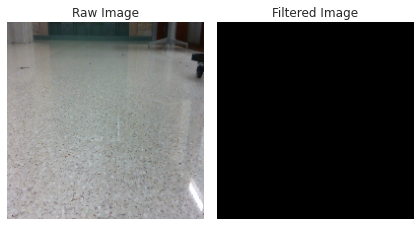

In [22]:
fig=plt.figure()
axes = []
axes.append( fig.add_subplot(1, 2, 1) )
axes[-1].set_title("Raw Image")  
plt.imshow(img)
plt.axis('off')

axes.append( fig.add_subplot(1, 2, 2) )
axes[-1].set_title("Filtered Image")  
plt.imshow(image, cmap='gray')
plt.axis('off')
fig.tight_layout()
plt.savefig('Part2_images.png')
plt.show()

In [5]:
data_arr = asarray(data_arr)
angular_arr = asarray(angular_arr)
print("x = ", np.shape(data_arr))
print("y = ", np.shape(angular_arr))

x =  (1913, 40000, 1)
y =  (1913, 1)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(data_arr, angular_arr, test_size=0.33, shuffle=True)
print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

(1281, 40000, 1)
(632, 40000, 1)
(1281, 1)
(632, 1)


In [7]:
train_len = int(x_train.shape[0]/10)
print("train_len ", train_len)

test_len = int(x_test.shape[0]/10)
print("test_len ", test_len)

train_len  128
test_len  63


In [8]:
x_trainset = np.split(x_train[:train_len*10], train_len)
y_trainset = np.split(y_train[:train_len*10], train_len)
x_testset = np.split(x_test[:test_len*10], test_len)
y_testset = np.split(y_test[:test_len*10], test_len)

In [9]:
x_trainset = np.asarray(x_trainset)
print(np.shape(x_trainset))
y_trainset = np.asarray(y_trainset)
print(np.shape(y_trainset))
x_testset = np.asarray(x_testset)
print(np.shape(x_testset))
y_testset = np.asarray(y_testset)
print(np.shape(y_testset))

(128, 10, 40000, 1)
(128, 10, 1)
(63, 10, 40000, 1)
(63, 10, 1)


In [10]:
wiring = kncp.wirings.NCP(
    inter_neurons=12,  # Number of inter neurons
    command_neurons=8,  # Number of command neurons
    motor_neurons=1,  # Number of motor neurons
    sensory_fanout=4,  # How many outgoing synapses has each sensory neuron
    inter_fanout=4,  # How many outgoing synapses has each inter neuron
    recurrent_command_synapses=4,  # Now many recurrent synapses are in the
    # command neuron layer
    motor_fanin=6,  # How many incomming syanpses has each motor neuron
)
rnn_cell = LTCCell(wiring)


model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 200*200, 1)),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(18, 5, strides=3, activation="relu")
        ),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(20, 5, strides=2, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool1D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(22, 5, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPool1D()),
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(24, 5, activation="relu")
        ),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.TimeDistributed(keras.layers.Dense(32, activation="relu")),
        keras.layers.RNN(rnn_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(0.001), loss="mean_squared_error")

model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
time_distributed (TimeDistributed)           (None, None, 13332, 18)                 108            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistributed)         (None, None, 6664, 20)                  1820           
____________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)         (None, None, 3332, 20)                  0              
____________________________________________________________________________________________________
time_distributed_3 (TimeDistributed)         (None, None, 3328, 22)                  2222           
_______________________________________________________________________

In [11]:
train = model.fit(
    x=x_trainset, y=y_trainset, batch_size=10, epochs=50, validation_data=(x_testset, y_testset)
)

Epoch 1/50
13/13 [==============================] - 12s 463ms/step - loss: 0.0482 - val_loss: 0.0427
Epoch 2/50
13/13 [==============================] - 5s 424ms/step - loss: 0.0383 - val_loss: 0.0372
Epoch 3/50
13/13 [==============================] - 5s 427ms/step - loss: 0.0360 - val_loss: 0.0359
Epoch 4/50
13/13 [==============================] - 6s 433ms/step - loss: 0.0352 - val_loss: 0.0354
Epoch 5/50
13/13 [==============================] - 5s 410ms/step - loss: 0.0349 - val_loss: 0.0353
Epoch 6/50
13/13 [==============================] - 5s 410ms/step - loss: 0.0348 - val_loss: 0.0353
Epoch 7/50
13/13 [==============================] - 5s 411ms/step - loss: 0.0348 - val_loss: 0.0352
Epoch 8/50
13/13 [==============================] - 6s 436ms/step - loss: 0.0347 - val_loss: 0.0352
Epoch 9/50
13/13 [==============================] - 6s 430ms/step - loss: 0.0346 - val_loss: 0.0352
Epoch 10/50
13/13 [==============================] - 6s 437ms/step - loss: 0.0346 - val_loss: 0.035

In [12]:
path = '/home/laiy/gitrepos/cyber/ws/src/Jackal_NCP/rosbag/model/model_line'
model.save(path)

INFO:tensorflow:Assets written to: /home/laiy/gitrepos/cyber/ws/src/Jackal_NCP/rosbag/model/model_line/assets


In [13]:
saved_model = tf.keras.models.load_model(path)
model = saved_model

In [14]:
test_loss = model.evaluate(x_testset,  y_testset, verbose=2)
print("test_loss ", test_loss) 


2/2 - 2s - loss: 0.0348
test_loss  0.034824516624212265


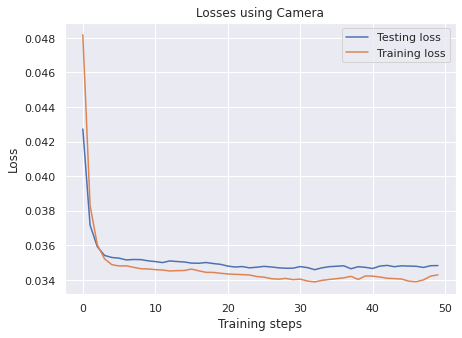

In [15]:
sns.set()
plt.figure(figsize=(7, 5))
plt.plot(train.history["val_loss"], label="Testing loss")
plt.plot(train.history["loss"], label="Training loss")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title('Losses using Camera')
plt.savefig('Part2_losses.png')
plt.show()


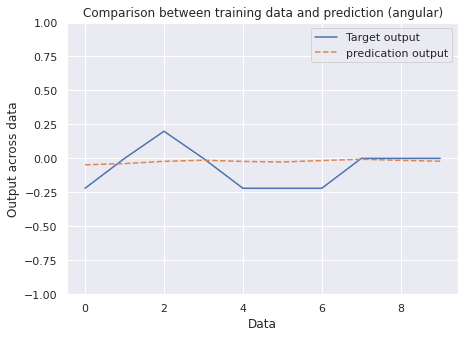

In [16]:
prediction = model(x_trainset).numpy()
plt.figure(figsize=(7, 5))
plt.plot(y_trainset[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="predication output",linestyle="dashed")
plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.ylabel("Output across data")
plt.xlabel("Data")
plt.title('Comparison between training data and prediction (angular)')
plt.savefig('Part2_training_result.png')
plt.show()


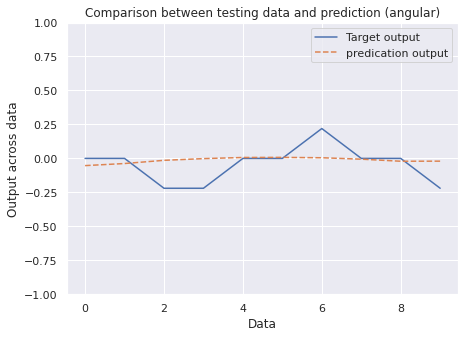

In [17]:
prediction = model(x_testset).numpy()
plt.figure(figsize=(7, 5))
plt.plot(y_testset[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="predication output",linestyle="dashed")
plt.ylim((-1, 1))
plt.legend(loc="upper right")

plt.ylabel("Output across data")
plt.xlabel("Data")
plt.title('Comparison between testing data and prediction (angular)')
plt.savefig('Part2_testing_result.png')
plt.show()


# Check Output

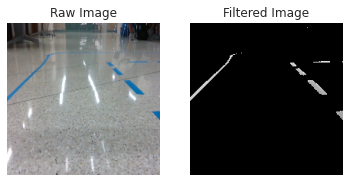

(1, 1, 40000, 1)
pred =  -0.053064417
ground =  0.0


In [25]:
image = cv.imread(image_path+'/'+'-0.9_image_ixnumpxluw.png', cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image,(200,200))

img = image
# range in BGR, cv.IMREAD_ANYCOLO
lower_range = np.array([0, 100, 150]) 
upper_range = np.array([100, 150, 200])   
mask = cv.inRange(img,lower_range,upper_range) 
result = cv.bitwise_and(img,img,mask = mask) 
result = cv.cvtColor(result, cv.COLOR_RGB2GRAY)

image = result
data = asarray(image)
data_flatten = np.transpose(data.flatten())
data_flatten = np.transpose(asarray([data_flatten]))
test = data_flatten

fig=plt.figure()
axes = []
axes.append( fig.add_subplot(1, 2, 1) )
axes[-1].set_title("Raw Image")  
plt.imshow(img)
plt.axis('off')

axes.append( fig.add_subplot(1, 2, 2) )
axes[-1].set_title("Filtered Image")  
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.savefig('Part2_images.png')
plt.show() 

test = np.array([[test]])
print(np.shape(test))

pred = model(test).numpy()[0][0][0]
pred = pred
print("pred = ", pred)
print("ground = ", y_testset[0][0][0])